###Install Library and preparing

In [1]:
!pip install -q torch
!pip install -q tf
!pip install -q gdown
!pip install -q transformers[torch] accelerate -U
!pip install -q accelerate -U
!pip install -q datasets
!pip install -q gensim
!pip install -q evaluate

###Import Library

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from collections import Counter
import tensorflow as tf
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, AutoConfig, TrainingArguments, EarlyStoppingCallback
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Flatten, concatenate, BatchNormalization,LSTM, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from datasets import load_dataset
import evaluate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import StratifiedKFold
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import BorderlineSMOTE, KMeansSMOTE, SVMSMOTE

import os
os.environ["WANDB_DISABLED"] = "true"

###Read Dataset and load Word2Vec

In [4]:
df = pd.read_csv("/content/pilpres_train_balanced_clean.csv")

In [5]:
df_test1 = pd.read_csv("/content/pilpres_test_clean.csv")

In [6]:
df.head()

,Text,Label
0,gayanya pemerannya prabowo gini ceritanya,0
1,ganjar kenalkan tawangmangu event siksorogo tr...,0
2,negara org cuman jelekin negara sendiringaku l...,0
3,politik identita fanatism belakangnya yg ahirn...,0
4,ya elahhh tetep ya bawa agama allah tidur tau ...,0


In [7]:
df.shape

(6274, 2)

In [8]:
print(df['Label'].value_counts())

Label
0    3137
1    3137
Name: count, dtype: int64


In [9]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gc.collect()
print(gensim.__version__)
# Load Pretrained Word Embeddings (Word2Vec)
# !gdown --id 1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
# !gdown --id 1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
# !gdown --id 1VUjxpH10baOw439V-YAAVVbtyI8iLgG5

4.4.0


In [10]:
import os
import shutil
import zipfile
import gdown
from google.colab import drive

drive_zip_name = 'model_w2v.zip'
drive_path = f'/content/drive/MyDrive/model_w2v/{drive_zip_name}'

file_id = '1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3'
url = f'https://drive.google.com/uc?id={file_id}'

final_model_name = 'idwiki_word2vec_768_new_lower.model'

if os.path.exists(final_model_name):
    print("Model is Available")

else:
    if not os.path.exists('/content/drive'):
        try:
            drive.mount('/content/drive')
        except:
            pass

    if os.path.exists(drive_path):
        shutil.copy(drive_path, '/content/model_w2v.zip')
    else:
        try:
            gdown.download(url, 'model_w2v.zip', quiet=False)
        except Exception as e:
            raise e

    # Extract
    if os.path.exists('model_w2v.zip'):
        print("Extracting...")
        with zipfile.ZipFile('model_w2v.zip', 'r') as zip_ref:
            zip_ref.extractall('/content/')

# Load Model
if os.path.exists(final_model_name):
    model = Word2Vec.load(final_model_name)
else:
    print("Failed")

Model is Available


In [11]:
word_embeddings = Word2Vec.load('/content/idwiki_word2vec_768_new_lower.model')
#word_embeddings = Word2Vec.load('/content/modelword2vec/idwiki_word2vec_768_new_lower.model')

###Split Dataset

In [12]:
x_train = df['Text']
y_train = df['Label']

In [13]:
x_test1 = df_test1['Text']
y_test1 = np.array(df_test1['Label'])

###Define Loss Function, Tokenization, Word Embeddings and Oversampling

In [14]:
# Define the margin loss function
def margin_loss(y_true, y_pred):
    margin = K.constant(0.1)
    y_true_float = K.cast(y_true, dtype='float32')  # Convert y_true to float32
    squared_difference_pos = K.square(K.maximum(0.9 - y_pred, 0))
    squared_difference_neg = K.square(K.maximum(y_pred - 0.1, 0))
    loss_pos = K.mean(y_true_float * squared_difference_pos)
    loss_neg = K.mean((1 - y_true_float) * squared_difference_neg)
    total_loss = loss_pos + lambda_val * loss_neg
    return total_loss

In [15]:
# # Define the model architectures
# #embedding_dim = 300
# #max_sequence_length = 100
lambda_val = 0.7  # Lambda value for margin loss
# #num_words = 100000

In [16]:
# Create word index
word_index = {word: index + 1 for index, word in enumerate(word_embeddings.wv.index_to_key)}

# Create embedding matrix
embedding_dim = word_embeddings.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word_embeddings.wv:
        embedding_vector = word_embeddings.wv[word]
        embedding_matrix[i] = embedding_vector


In [17]:
tokenizer = Tokenizer(num_words=len(word_index) + 1, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train.astype(str).fillna(''))

# Convert text to sequences and pad
x_train_sequences = tokenizer.texts_to_sequences(x_train.astype(str).fillna(''))
x_test_sequences1 = tokenizer.texts_to_sequences(x_test1.astype(str).fillna(''))
# x_test_sequences2 = tokenizer.texts_to_sequences(x_test2)
# x_test_sequences3 = tokenizer.texts_to_sequences(x_test3)

# Determine max sequence length based on your data
max_sequence_length = max(max(len(seq) for seq in x_train_sequences), max(len(seq) for seq in x_test_sequences1))

x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sequence_length, padding='post')
x_test_padded1 = pad_sequences(x_test_sequences1, maxlen=max_sequence_length, padding='post')
# x_test_padded2 = pad_sequences(x_test_sequences2, maxlen=max_sequence_length, padding='post')
# x_test_padded3 = pad_sequences(x_test_sequences3, maxlen=max_sequence_length, padding='post')


In [18]:
x_train_flat = x_train_padded.reshape(x_train_padded.shape[0], -1)

####Oversampling with BorderlineSMOTE

In [19]:
borderline_smote = BorderlineSMOTE(random_state=42)
x_train_resampled_flat_borderline, y_train_resampled_borderline = borderline_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_borderline = x_train_resampled_flat_borderline.reshape(x_train_resampled_flat_borderline.shape[0], max_sequence_length)

####Oversampling with KMeansSMOTE

In [20]:
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.2)
x_train_resampled_flat_kmeans, y_train_resampled_kmeans = kmeans_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_kmeans = x_train_resampled_flat_kmeans.reshape(x_train_resampled_flat_kmeans.shape[0], max_sequence_length)

####Oversampling with SVMSMOTE

In [21]:
svm_smote = SVMSMOTE(random_state=42)
x_train_resampled_flat_svm, y_train_resampled_svm = svm_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_svm = x_train_resampled_flat_svm.reshape(x_train_resampled_flat_svm.shape[0], max_sequence_length)

In [22]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


##CNN Model

In [24]:
# Define the architecture of the static model with he_normal initialization
static_input = Input(shape=(max_sequence_length,))
static_embedding = Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length, trainable=False)(static_input)  # Removed weights parameter

#Convolutional Layers
static_cnn_output = Conv1D(128, 3, activation='relu', kernel_initializer=he_normal())(static_embedding)  # Use he_normal initialization
static_cnn_output = MaxPooling1D(2)(static_cnn_output)
static_cnn_output = GlobalMaxPooling1D()(static_cnn_output)
static_cnn_output = Dropout(0.5)(static_cnn_output)
batch_norm_layer = BatchNormalization()(static_cnn_output)

#Fully Connected Layers
static_dense_output = Dense(128, activation='relu', kernel_initializer=he_normal())(batch_norm_layer)  # Use he_normal initialization
static_dense_output = Dropout(0.5)(static_dense_output)
output = Dense(1, activation='sigmoid')(static_dense_output)

# Create the static model
static_model = Model(inputs=static_input, outputs=output)
static_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

###CNN BorderlineSMOTE Train and Test

In [25]:
# Train the static model
epochs_static = 10
history_static = static_model.fit(
    x_train_resampled_borderline,
    y_train_resampled_borderline,
    batch_size=32,
    epochs=epochs_static,
    validation_split=0.1,
    callbacks=[early_stopping],
)



Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5877 - loss: 0.1507 - val_accuracy: 0.6656 - val_loss: 0.1433
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8491 - loss: 0.0561 - val_accuracy: 0.9570 - val_loss: 0.0564
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9295 - loss: 0.0280 - val_accuracy: 0.9825 - val_loss: 0.0138
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9539 - loss: 0.0196 - val_accuracy: 0.9952 - val_loss: 0.0039
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9627 - loss: 0.0164 - val_accuracy: 0.9889 - val_loss: 0.0032
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9724 - loss: 0.0124 - val_accuracy: 0.9825 - val_loss: 0.0044
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9742 - loss: 0.0107 - val_accuracy: 0.9889 - val_loss: 0.0038
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9705 - loss: 0.0126 - val_accuracy: 

####Cross-Validation Train

In [26]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [27]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_borderline)
y_train_np = np.array(y_train_resampled_borderline)

In [28]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_static = []
val_accuracies_static = []
train_losses_static = []
val_losses_static = []
classification_reports = []
# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    static_model = Model(inputs=static_input, outputs=output)

    static_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    static = static_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        epochs=epochs_static,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_static, train_accuracy_static = static_model.evaluate(x_train_fold, y_train_fold)
    val_loss_static, val_accuracy_static = static_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_static}, Training Accuracy: {train_accuracy_static}")
    print(f"Fold {fold} - Validation Loss: {val_loss_static}, Validation Accuracy: {val_accuracy_static}")

    # Store the results for this fold
    train_accuracies_static.append(train_accuracy_static)
    val_accuracies_static.append(val_accuracy_static)
    train_losses_static.append(train_loss_static)
    val_losses_static.append(val_loss_static)

    # Evaluate the model
    y_pred = (static_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)



Training fold 1/10
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9776 - loss: 0.0104 - val_accuracy: 1.0000 - val_loss: 1.5847e-04
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9785 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 2.6852e-04
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9764 - loss: 0.0109 - val_accuracy: 1.0000 - val_loss: 2.3112e-05
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9804 - loss: 0.0085 - val_accuracy: 1.0000 - val_loss: 2.6099e-04
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9783 - loss: 0.0086 - val_accuracy: 1.0000 - val_loss: 2.1936e-04
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9780 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 8.6239e-05
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9954 - loss: 0.0021
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5443e-05 
Fold 1 - Training Loss: 0.001613252

In [29]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_static) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_static]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_static) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_static]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_static) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_static]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_static) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_static]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.997573721408844, Std Training Accuracy: 0.0006862720202867517
Mean Training Loss: 0.0011632623150944709, Std Training Loss: 0.0002592225025250935
Mean Validation Accuracy: 0.9979281485080719, Std Validation Accuracy: 0.0018929453178899221
Mean Validation Loss: 0.0009837215140560574, Std Validation Loss: 0.0008993178097143156


In [30]:
avg_report = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports]),
        'support': np.sum([r['0']['support'] for r in classification_reports])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports]),
        'support': np.sum([r['1']['support'] for r in classification_reports])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(1.0), 'recall': np.float64(0.9958221017853945), 'f1-score': np.float64(0.997903015755403), 'support': np.float64(3137.0)}, 'Class 1': {'precision': np.float64(0.9959131859594944), 'recall': np.float64(1.0), 'f1-score': np.float64(0.9979489164407511), 'support': np.float64(3137.0)}}


In [31]:
print(history_static.history.keys())
num_epochs = len(history_static.history['loss'])
print(f"Number of epochs: {num_epochs}")

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Number of epochs: 10


In [32]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_CNN_BorderlineSMOTE.csv'

# Define headers for training and validation metrics

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []

num_epochs = len(history_static.history['loss'])
print(f"Number of epochs: {num_epochs}")

# Collect the metrics and populate the data
for epoch in range(num_epochs):
    # Training metrics for the current epoch
    train_loss = history_static.history['loss'][epoch]
    train_accuracy = history_static.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_static.history['val_loss'][epoch]
    val_accuracy = history_static.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


Number of epochs: 10


####Testing

In [33]:
# Evaluate the static model
static_evaluation1 = static_model.evaluate(x_test_padded1, y_test1, batch_size=32)
static_accuracy1 = static_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", static_accuracy1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9277 - loss: 0.0499 
Static Model Evaluation Results:
Accuracy: 0.9270833134651184


In [34]:
y_test_pred1 = (static_model.predict(x_test_padded1) > 0.1).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       349
           1       0.50      0.40      0.44        35

    accuracy                           0.91       384
   macro avg       0.72      0.68      0.70       384
weighted avg       0.90      0.91      0.90       384



###CNN KmeansSMOTE Train and Test

In [35]:
# Create the static model
static_model = Model(inputs=static_input, outputs=output)
static_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

In [36]:
# Train the static model
epochs_static = 10
history_static_kmeans = static_model.fit(
    x_train_resampled_kmeans,
    y_train_resampled_kmeans,
    batch_size=32,
    epochs=epochs_static,
    validation_split=0.1,
    callbacks=[early_stopping],
)



Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9881 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9909 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 8.5080e-05
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9876 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 1.9303e-06


####Cross-Validation Train

In [37]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [38]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_kmeans)
y_train_np = np.array(y_train_resampled_kmeans)

In [39]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_static = []
val_accuracies_static = []
train_losses_static = []
val_losses_static = []
classification_reports = []
# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    static_model = Model(inputs=static_input, outputs=output)

    static_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    static = static_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        epochs=epochs_static,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_static, train_accuracy_static = static_model.evaluate(x_train_fold, y_train_fold)
    val_loss_static, val_accuracy_static = static_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_static}, Training Accuracy: {train_accuracy_static}")
    print(f"Fold {fold} - Validation Loss: {val_loss_static}, Validation Accuracy: {val_accuracy_static}")

    # Store the results for this fold
    train_accuracies_static.append(train_accuracy_static)
    val_accuracies_static.append(val_accuracy_static)
    train_losses_static.append(train_loss_static)
    val_losses_static.append(val_loss_static)

    # Evaluate the model
    y_pred = (static_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)



Training fold 1/10
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9865 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 4.9662e-05
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9885 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 4.5842e-06
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9838 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9907 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9920 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 9.6586e-07
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9900 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9982 - loss: 8.3326e-04
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 
Fold 1 - Training Loss: 0.00074

In [40]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_static) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_static]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_static) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_static]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_static) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_static]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_static) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_static]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.9989728093147278, Std Training Accuracy: 0.00034347416929657494
Mean Training Loss: 0.00048788739513838664, Std Training Loss: 0.00018633942803769312
Mean Validation Accuracy: 0.9990440785884858, Std Validation Accuracy: 0.0010565597286872116
Mean Validation Loss: 0.0005293171307584998, Std Validation Loss: 0.0005588655365755625


In [41]:
avg_report = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports]),
        'support': np.sum([r['0']['support'] for r in classification_reports])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports]),
        'support': np.sum([r['1']['support'] for r in classification_reports])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(1.0), 'recall': np.float64(0.9980601485892568), 'f1-score': np.float64(0.9990279988322353), 'support': np.float64(3137.0)}, 'Class 1': {'precision': np.float64(0.9981192321105705), 'recall': np.float64(1.0), 'f1-score': np.float64(0.999057628879805), 'support': np.float64(3137.0)}}


In [42]:
print(history_static_kmeans.history.keys())
num_epochs = len(history_static_kmeans.history['loss'])
print(f"Number of epochs: {num_epochs}")

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Number of epochs: 4


In [43]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_CNN_KmeansSMOTE.csv'

# Define headers for training and validation metrics

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []

num_epochs = len(history_static_kmeans.history['loss'])
print(f"Number of epochs: {num_epochs}")

# Collect the metrics and populate the data
for epoch in range(num_epochs):
    # Training metrics for the current epoch
    train_loss = history_static_kmeans.history['loss'][epoch]
    train_accuracy = history_static_kmeans.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_static_kmeans.history['val_loss'][epoch]
    val_accuracy = history_static_kmeans.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


Number of epochs: 4


In [44]:
all_metrics

[[1, 0.006101715844124556, 0.986893355846405, 0.0, 1.0],
 [2, 0.00513186352327466, 0.9888416528701782, 0.0, 1.0],
 [3, 0.00511076208204031, 0.9884874224662781, 8.508006430929527e-05, 1.0],
 [4, 0.00491806585341692, 0.9888416528701782, 1.930283360707108e-06, 1.0]]

In [45]:
# print(f"x_test_padded1 shape: {x_test_padded1.shape}")
# print(f"y_test1 shape: {y_test1.shape}")

####Testing

In [46]:
# Evaluate the static model
static_evaluation1 = static_model.evaluate(x_test_padded1, y_test1, batch_size=32)
static_accuracy1 = static_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", static_accuracy1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9124 - loss: 0.0563 
Static Model Evaluation Results:
Accuracy: 0.921875


In [47]:
y_test_pred1 = (static_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       349
           1       0.65      0.31      0.42        35

    accuracy                           0.92       384
   macro avg       0.79      0.65      0.69       384
weighted avg       0.91      0.92      0.91       384



In [48]:
# Run garbage collection
gc.collect()

12499

###CNN SVMSMOTE Train and Test

In [49]:
# Create the static model
static_model = Model(inputs=static_input, outputs=output)
static_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

In [50]:
# Train the static model
epochs_static = 10
history_static_svm = static_model.fit(
    x_train_resampled_svm,
    y_train_resampled_svm,
    batch_size=32,
    epochs=epochs_static,
    validation_split=0.1,
    callbacks=[early_stopping],
)



Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9958 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9908 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9920 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


####Cross-Validation Train

In [51]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [52]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_svm)
y_train_np = np.array(y_train_resampled_svm)

In [53]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_static = []
val_accuracies_static = []
train_losses_static = []
val_losses_static = []
classification_reports = []
# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    static_model = Model(inputs=static_input, outputs=output)

    static_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    static = static_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        epochs=epochs_static,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_static, train_accuracy_static = static_model.evaluate(x_train_fold, y_train_fold)
    val_loss_static, val_accuracy_static = static_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_static}, Training Accuracy: {train_accuracy_static}")
    print(f"Fold {fold} - Validation Loss: {val_loss_static}, Validation Accuracy: {val_accuracy_static}")

    # Store the results for this fold
    train_accuracies_static.append(train_accuracy_static)
    val_accuracies_static.append(val_accuracy_static)
    train_losses_static.append(train_loss_static)
    val_losses_static.append(val_loss_static)

    # Evaluate the model
    y_pred = (static_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)



Training fold 1/10
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9954 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9949 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9942 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9993 - loss: 4.2387e-04
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 
Fold 1 - Training Loss: 0.0003007409395650029, Training Accuracy: 0.9994686245918274
Fold 1 - Validation Loss: 0.0, Validation Accuracy: 1.0
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       327
     

In [54]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_static) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_static]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_static) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_static]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_static) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_static]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_static) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_static]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.9995749533176422, Std Training Accuracy: 0.00011749392837319816
Mean Training Loss: 0.00022299166594166308, Std Training Loss: 8.301293004880214e-05
Mean Validation Accuracy: 0.9995217859745026, Std Validation Accuracy: 0.0007304842898312412
Mean Validation Loss: 0.00025757913758752695, Std Validation Loss: 0.0003913168078760471


In [55]:
avg_report = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports]),
        'support': np.sum([r['0']['support'] for r in classification_reports])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports]),
        'support': np.sum([r['1']['support'] for r in classification_reports])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(1.0), 'recall': np.float64(0.9990263933149952), 'f1-score': np.float64(0.9995124040578759), 'support': np.float64(3137.0)}, 'Class 1': {'precision': np.float64(0.9990601261535108), 'recall': np.float64(1.0), 'f1-score': np.float64(0.9995293246992185), 'support': np.float64(3137.0)}}


In [56]:
print(history_static_svm.history.keys())
num_epochs = len(history_static_svm.history['loss'])
print(f"Number of epochs: {num_epochs}")

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Number of epochs: 4


In [57]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_CNN_SVMSMOTE.csv'

# Define headers for training and validation metrics

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []

num_epochs = len(history_static_svm.history['loss'])
print(f"Number of epochs: {num_epochs}")

# Collect the metrics and populate the data
for epoch in range(num_epochs):
    # Training metrics for the current epoch
    train_loss = history_static_svm.history['loss'][epoch]
    train_accuracy = history_static_svm.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_static_svm.history['val_loss'][epoch]
    val_accuracy = history_static_svm.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


Number of epochs: 4


In [58]:
all_metrics

[[1, 0.002542527625337243, 0.9939780235290527, 0.0, 1.0],
 [2, 0.0034377414267510176, 0.9923840165138245, 0.0, 1.0],
 [3, 0.003664902411401272, 0.9914984107017517, 0.0, 1.0],
 [4, 0.003310499247163534, 0.9923840165138245, 0.0, 1.0]]

####Testing

In [59]:
# Evaluate the static model
static_evaluation1 = static_model.evaluate(x_test_padded1, y_test1, batch_size=32)
static_accuracy1 = static_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", static_accuracy1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9286 - loss: 0.0492 
Static Model Evaluation Results:
Accuracy: 0.9296875


In [60]:
y_test_pred1 = (static_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       349
           1       0.79      0.31      0.45        35

    accuracy                           0.93       384
   macro avg       0.86      0.65      0.71       384
weighted avg       0.92      0.93      0.92       384



##Evaluation

In [61]:
torch.cuda.empty_cache()

In [62]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

###CNN

####BorderlineSMOTE

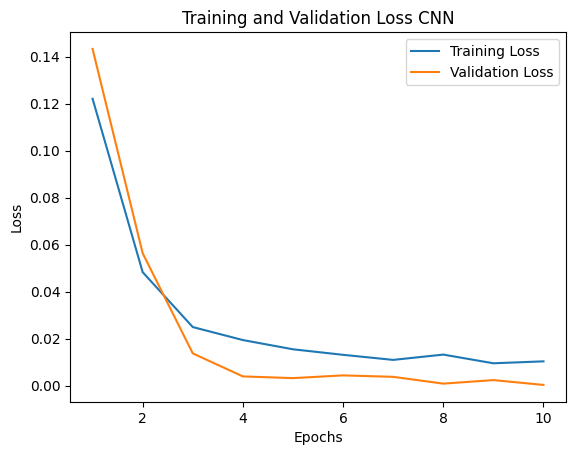

In [63]:
import matplotlib.pyplot as plt
train_loss_static = history_static.history['loss']
val_loss_static = history_static.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_static) + 1), train_loss_static, label='Training Loss')
plt.plot(range(1, len(val_loss_static) + 1), val_loss_static, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss CNN')
plt.legend()
plt.show()

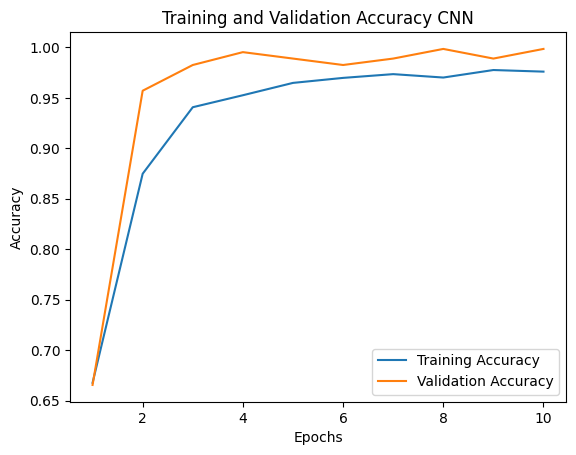

In [64]:
import matplotlib.pyplot as plt
accuracy_static = history_static.history['accuracy']
val_accuracy_static = history_static.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_static) + 1), accuracy_static, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_static) + 1), val_accuracy_static, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy CNN')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


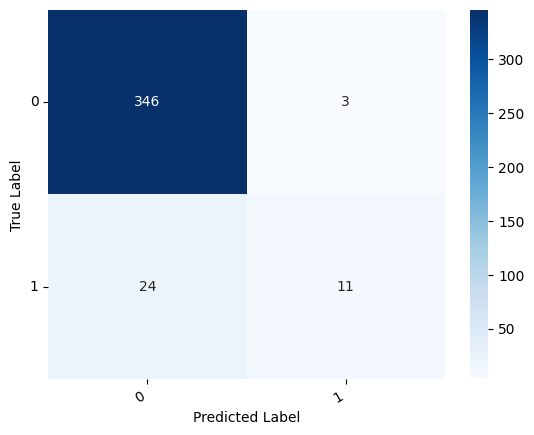

In [65]:
predictions_static_1 = static_model.predict(x_test_padded1)
predicted_labels_static_1 = (predictions_static_1 > 0.5).astype(int)
cm_static_1 = confusion_matrix(y_test1,predicted_labels_static_1)
show_confusion_matrix(cm_static_1)

####KMeansSMOTE

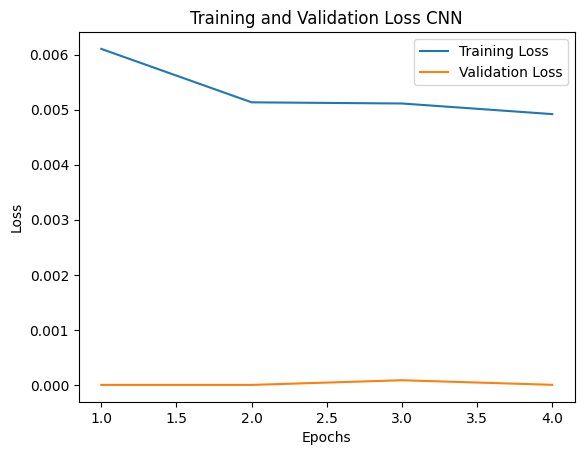

In [66]:
import matplotlib.pyplot as plt
train_loss_static = history_static_kmeans.history['loss']
val_loss_static = history_static_kmeans.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_static) + 1), train_loss_static, label='Training Loss')
plt.plot(range(1, len(val_loss_static) + 1), val_loss_static, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss CNN')
plt.legend()
plt.show()

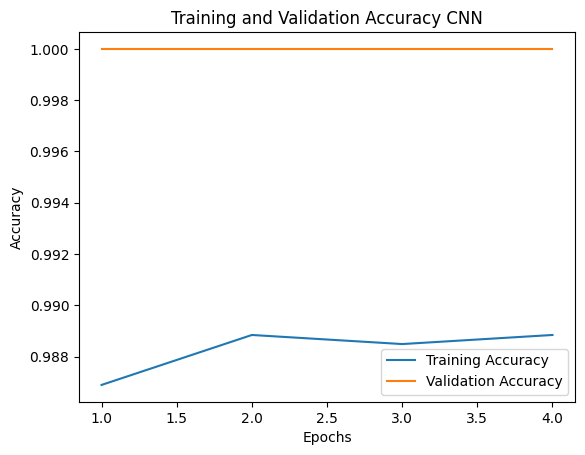

In [67]:
import matplotlib.pyplot as plt
accuracy_static = history_static_kmeans.history['accuracy']
val_accuracy_static = history_static_kmeans.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_static) + 1), accuracy_static, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_static) + 1), val_accuracy_static, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy CNN')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


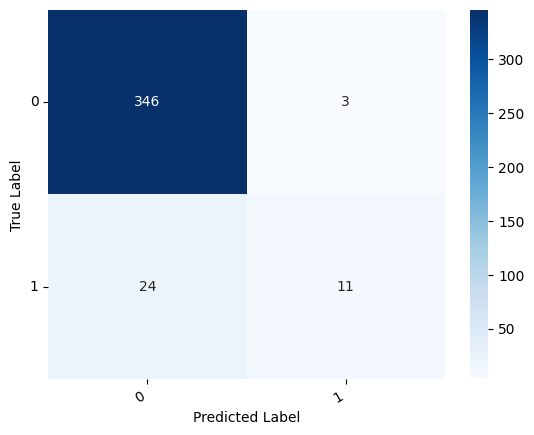

In [68]:
predictions_static_1 = static_model.predict(x_test_padded1)
predicted_labels_static_1 = (predictions_static_1 > 0.5).astype(int)
cm_static_1 = confusion_matrix(y_test1,predicted_labels_static_1)
show_confusion_matrix(cm_static_1)

####SVMSMOTE

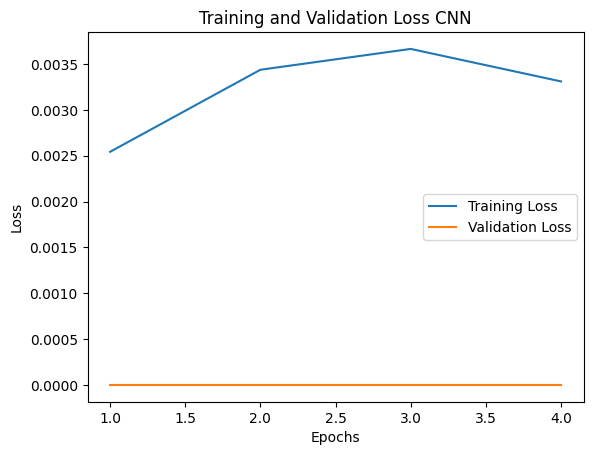

In [69]:
import matplotlib.pyplot as plt
train_loss_static = history_static_svm.history['loss']
val_loss_static = history_static_svm.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_static) + 1), train_loss_static, label='Training Loss')
plt.plot(range(1, len(val_loss_static) + 1), val_loss_static, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss CNN')
plt.legend()
plt.show()

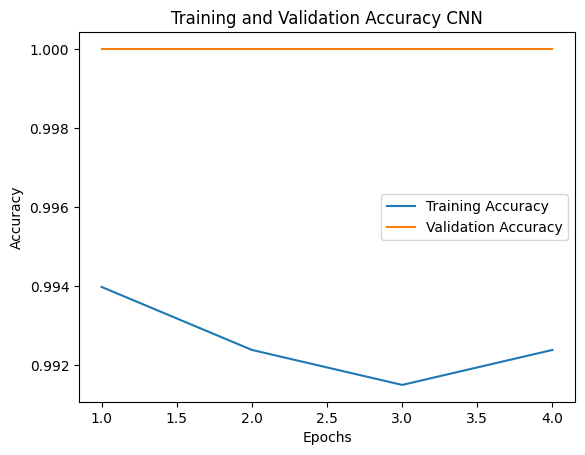

In [70]:
import matplotlib.pyplot as plt
accuracy_static = history_static_svm.history['accuracy']
val_accuracy_static = history_static_svm.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_static) + 1), accuracy_static, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_static) + 1), val_accuracy_static, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy CNN')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


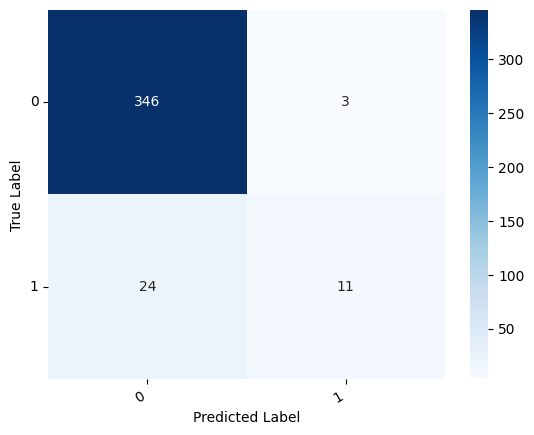

In [71]:
predictions_static_1 = static_model.predict(x_test_padded1)
predicted_labels_static_1 = (predictions_static_1 > 0.5).astype(int)
cm_static_1 = confusion_matrix(y_test1,predicted_labels_static_1)
show_confusion_matrix(cm_static_1)